In [1]:
############################################
# 
# Marcus Bischof
# Divvy EDA : Chicago
#
############################################

# Operations
import pandas as pd
import numpy as np

# Image libs
from PIL import Image, ImageChops
from folium.raster_layers import ImageOverlay

# Custom functions
from functions_for_eda import *

# Data viz
from matplotlib import pyplot as plt
import seaborn as sns

# Maps
import folium
from folium import plugins

# Jupyter display
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# Do we need to load raw .csv, and create a single memory efficient .pkl?
CREATE_SMALL_MEMORY_SET = False
if CREATE_SMALL_MEMORY_SET:
    create_memory_efficient_pkl()

# Do we want to break up the 860+mb memory efficient .pkl into 10 slices?
CREATE_SLICES_OF_MEMORY_EFFICIENT_PKL = False
if CREATE_SLICES_OF_MEMORY_EFFICIENT_PKL:
    create_slices_of_memory_efficient_pkl()

# One tenth of the divvy data, to be used for exploration.
df = pd.read_pickle('../data/interim/df_0_1000000.pkl')
# Neighborhoods and geo.
n_hood = load_geojson_neighborhood_data()
stations = pd.read_pickle('../data/processed/stations.pkl')

# Divvy Data Description on Kaggle's Site
------------

-  __trip_idID__ attached to each trip taken
-  __year__ year
-  __month__ month
-  __week__ week No.
-  __day__
-  __hour__
-  __usertype__ 
    -  _Customer_ is a rider who purchased a 24-Hour Pass
    -  _Subscriber_ is a rider who purchased an Annual -  Membership
-  __gender__
-  __starttime__ day and time trip started, in CST
-  __stoptime__ day and time trip ended, in CST
-  __tripduration__ time of trip in minutes
-  __temperature__
-  __events__
-  __from_station_id__ ID of station where trip originated
-  __from_station_name__ name of station where trip terminated
-  __latitude_start__ station latitude
-  __longitude_start__ station longitude
-  __dpcapacity_start__ number of total docks at each station
-  __to_station_id__
-  __to_station_name__
-  __latitude_end__
-  __longitude_end__
-  __dpcapacity_end__ number of total docks at each station

# Custom Functions that I wrote for this Analysis
------------

-  __To create a map.__
```
create_chicago_map()
```

-  __To add points to a map.__ \*\*Note: icon must be a font-awesome icon.
```
add_points_to_map
(
        folium_map_obj, color, icon, points
)
```

-  __To add a neighborhood overlay.__
```
add_neighborhood_overlay_to_map
(
        folium_map_obj, neighborhood_name, color, n_hood_df_polylines
)
```

In [2]:
m = create_chicago_map()

In [3]:
# Thanks to https://alysivji.github.io/getting-started-with-folium.html
stations_starts = stations[['lat', 'long']].values

# plot heatmap
m.add_child(plugins.HeatMap(stations_starts, radius=10))
m

We see a signficant concentration of <i><b>divvy stations</b></i> in:
    -  The loop
    -  Northern neighborhoods on the lake like Lincoln Park 
    
For our analysis, let's first understand the data broadly. 

We will <i><b>then</b></i> start with a neighborhood centric approach to analyzing the data. I believe that since neighborhoods contain residents that may share certain commonalities, we may see interesting trends <i><b>among</b></i> and <i><b>between</b></i> various neighborhoods.

In [4]:
df.head()

,trip_id,year,month,week,day,hour,usertype,gender,starttime,stoptime,tripduration,temperature,events,from_station_id,from_station_name,latitude_start,longitude_start,dpcapacity_start,to_station_id,to_station_name,latitude_end,longitude_end,dpcapacity_end,from_neighborhood,to_neighborhood,same_station_trip,same_neighborhood_trip
0,2355134,2014,6,27,0,23,Subscriber,Male,2014-06-30 23:57:00,2014-07-01 00:07:00,10,68,tstorms,131,Lincoln Ave & Belmont Ave,41.939365,-87.668385,15,303,Broadway & Cornelia Ave,41.945512,-87.645980,15,Lake View,Lake View,False,True
1,2355133,2014,6,27,0,23,Subscriber,Male,2014-06-30 23:56:00,2014-07-01 00:00:00,4,68,tstorms,282,Halsted St & Maxwell St,41.864580,-87.646930,15,22,May St & Taylor St,41.869482,-87.655486,15,"Little Italy, UIC","Little Italy, UIC",False,True
2,2355130,2014,6,27,0,23,Subscriber,Male,2014-06-30 23:33:00,2014-06-30 23:35:00,2,68,tstorms,327,Sheffield Ave & Webster Ave,41.921687,-87.653714,19,225,Halsted St & Dickens Ave,41.919936,-87.648830,15,Lincoln Park,Lincoln Park,False,True
3,2355129,2014,6,27,0,23,Subscriber,Female,2014-06-30 23:26:00,2014-07-01 00:24:00,58,68,tstorms,134,Peoria St & Jackson Blvd,41.877749,-87.649633,19,194,State St & Wacker Dr,41.887155,-87.627750,11,West Loop,Loop,False,False
4,2355128,2014,6,27,0,23,Subscriber,Female,2014-06-30 23:16:00,2014-06-30 23:26:00,10,68,tstorms,320,Loomis St & Lexington St,41.872187,-87.661501,15,134,Peoria St & Jackson Blvd,41.877749,-87.649633,19,"Little Italy, UIC",West Loop,False,False


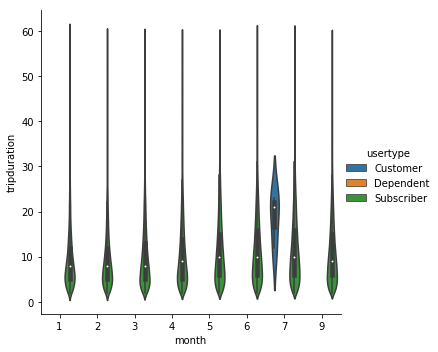

In [5]:
g = sns.catplot(
    x="month", y="tripduration", hue="usertype",
    data=df, kind="violin"
)

In [6]:
df[['month', 'usertype', 'tripduration']].groupby(['month', 'usertype']).mean().dropna(how='any')

tripduration
month usertype                
1     Subscriber      9.275141
2     Subscriber      9.382594
3     Subscriber      9.945430
4     Subscriber     10.507275
5     Subscriber     11.367555
6     Subscriber     11.744595
7     Customer       18.666667
      Subscriber     11.769901
9     Subscriber     10.969968

# Trip Duration Analysis Below

It seems as though we are only getting customer data from <i><b>July</b></i>.

How much does trip duration vary across event types?

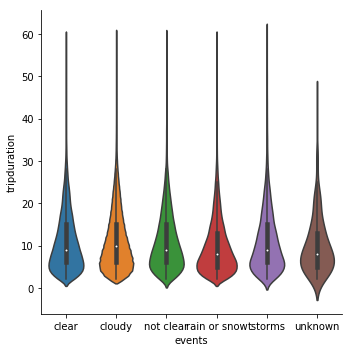

In [7]:
g = sns.catplot(
    x="events", y="tripduration",
    data=df, kind="violin"
)

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

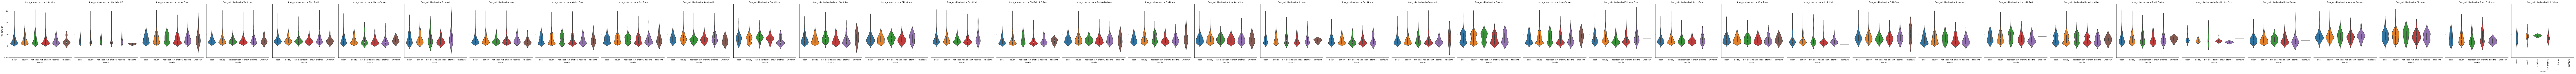

In [8]:
g = sns.catplot(
    x="events", y="tripduration", col="from_neighborhood",
    data=df, kind="violin"
)
plt.xticks(rotation=90)

In [9]:
trip_durations_by_hood = df[['from_neighborhood', 'tripduration']].groupby(['from_neighborhood']).agg(['count', 'mean']).sort_values([('tripduration', 'mean')], ascending=False).reset_index()

In [10]:
trip_durations_by_hood.head()

from_neighborhood tripduration           
                           count       mean
0         Edgewater         1551  18.249516
1     Museum Campus         5059  17.127100
2    Little Village          222  15.981982
3           Douglas         6749  14.659505
4        Gold Coast        13179  14.650049

Let's add the top 5 neighborhoods (by average tripduration) to the map. Anything in common here?

In [11]:
for top_hood in ['Edgewater', 'Museum Campus', 'Little Village', 'Douglas', 'Gold Coast']:
    add_neighborhood_overlay_to_map(m, top_hood, 'red', n_hood)
m

I am certainly gettting the impression that the top neighborhoods in terms of average trip duration are actually neighborhoods with a small amount of stations, this makes sense.

We will do the following:
    -  The top neighborhoods (1 --> 13): yellow
    -  The middle neighborhoods (14 --> 26): green
    -  The bottom neighborhoods (27 --> 39): blue

In [12]:
neighborhood_map = create_chicago_map()
i = 1
for neighborhood in trip_durations_by_hood.itertuples():
    color = ''
    if i <= 13:
        color = 'yellow'
    elif 14 <= i <= 26:
        color = 'green'
    else:
        color = 'blue'
    i += 1
    add_neighborhood_overlay_to_map(neighborhood_map, neighborhood[1], color, n_hood)
    
def trim(img):
    border = Image.new(img.mode, img.size, img.getpixel((0, 0)))
    diff = ImageChops.difference(img, border)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        img = img.crop(bbox)
    return np.array(img)

with Image.open('avg_trip_duration.png') as img:
    image = trim(img)

# We add our legend as an image.
ImageOverlay(
    image=image,
    bounds=[[41.954883, -87.594551], [41.894883, -87.494551]],
    zindex=1,
).add_to(neighborhood_map)

neighborhood_map

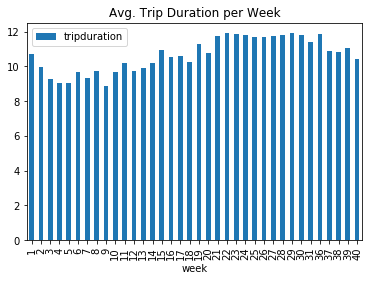

In [13]:
df[['week', 'tripduration']].groupby('week').mean().plot.bar(title="Avg. Trip Duration per Week")

Confirm below that week one corresponds to the first week of january as expected. The <font color='green'>chart above</font> makes sense now, as we would expect the average duration of trips to be shorter in the winter and longer in the summer.

In [14]:
df[df.week == 1].head()

,trip_id,year,month,week,day,hour,usertype,gender,starttime,stoptime,tripduration,temperature,events,from_station_id,from_station_name,latitude_start,longitude_start,dpcapacity_start,to_station_id,to_station_name,latitude_end,longitude_end,dpcapacity_end,from_neighborhood,to_neighborhood,same_station_trip,same_neighborhood_trip
576002,1110948,2014,1,1,6,14,Subscriber,Male,2014-01-05 14:54:00,2014-01-05 15:02:00,7,12,rain or snow,197,Michigan Ave & Madison St,41.882134,-87.625125,19,191,Canal St & Monroe St,41.880700,-87.639470,23,Loop,West Loop,False,False
576003,1110947,2014,1,1,6,14,Subscriber,Male,2014-01-05 14:47:00,2014-01-05 14:57:00,9,12,rain or snow,20,Sheffield Ave & Kingsbury St,41.909592,-87.653497,15,48,Larrabee St & Kingsbury St,41.897764,-87.642884,27,River North,River North,False,True
576004,1110946,2014,1,1,6,14,Subscriber,Male,2014-01-05 14:38:00,2014-01-05 14:47:00,8,12,rain or snow,21,Aberdeen St & Jackson Blvd,41.877726,-87.654787,15,71,Morgan St & Lake St,41.885483,-87.652305,15,West Loop,West Loop,False,True
576005,1110936,2014,1,1,6,14,Subscriber,Male,2014-01-05 14:16:00,2014-01-05 14:33:00,16,12,rain or snow,191,Canal St & Monroe St,41.880700,-87.639470,23,111,Sedgwick St & Huron St,41.894666,-87.638437,19,West Loop,River North,False,False
576006,1110935,2014,1,1,6,14,Subscriber,Male,2014-01-05 14:03:00,2014-01-05 14:17:00,13,12,rain or snow,48,Larrabee St & Kingsbury St,41.897764,-87.642884,27,20,Sheffield Ave & Kingsbury St,41.909592,-87.653497,15,River North,River North,False,True


# Station Capacity Analysis Below

In [15]:
df[['from_station_name', 'to_station_name', 'dpcapacity_start', 'dpcapacity_end']].groupby(['from_station_name', 'to_station_name']).mean().dropna()

dpcapacity_start  \
from_station_name          to_station_name                                          
900 W Harrison             900 W Harrison                               19.000000   
                           Aberdeen St & Jackson Blvd                   19.000000   
                           Aberdeen St & Madison St                     19.000000   
                           Ada St & Washington Blvd                     19.000000   
                           Ashland Ave & 13th St                        19.000000   
                           Ashland Ave & 21st St                        19.000000   
                           Ashland Ave & Augusta Blvd                   19.000000   
                           Ashland Ave & Chicago Ave                    19.000000   
                           Ashland Ave & Division St                    19.000000   
                           Ashland Ave & Grand Ave                      19.000000   
                           Ashland Ave & Lake St                        19.000000   
                           Blue Island Ave & 18th St                    19.000000   
                           California Ave & 21st St                     19.000000   
                           California Ave & Division St                 19.000000   
                           California Ave & Milwaukee Ave               19.000000   
                           Canal St & Adams St                          19.000000   
                           Canal St & Harrison St                       19.000000   
                           Canal St & Jackson Blvd                      19.000000   
                           Canal St & Madison St                        19.000000   
                           Canal St & Monroe St                         19.000000   
                           Carpenter St & Huron St                      19.000000   
                           Clark St & Randolph St                       19.000000   
                           Clark St & Schiller St                       19.000000   
                           Clark St & Waveland Ave                      19.000000   
                           Clinton St & Lake St                         19.000000   
                           Clinton St & Madison St                      19.000000   
                           Clinton St & Roosevelt Rd                    19.000000   
                           Clinton St & Washington Blvd                 19.000000   
                           Daley Center Plaza                           19.000000   
                           Damen Ave & Augusta Blvd                     19.000000   
                           Damen Ave & Charleston St                    19.000000   
                           Damen Ave & Chicago Ave                      19.000000   
                           Damen Ave & Cortland St                      19.000000   
                           Damen Ave & Cullerton St                     19.000000   
                           Damen Ave & Division St                      19.000000   
                           Damen Ave & Grand Ave                        19.000000   
                           Damen Ave & Madison St                       19.000000   
                           Damen Ave & Pierce Ave                       19.000000   
                           Dayton St & North Ave                        19.000000   
                           Dearborn Pkwy & Delaware Pl                  19.000000   
                           Dearborn St & Adams St                       19.000000   
                           Dearborn St & Monroe St                      19.000000   
                           Desplaines St & Kinzie St                    19.000000   
                           Eckhart Park                                 19.000000   
                           Emerald Ave & 28th St                        19.000000   
                           Emerald Ave & 31st St                      

In [16]:
len(df[(df.from_neighborhood == 'Wicker Park') & (df.to_neighborhood != 'Wicker Park')])

23842

We want to understand how capacity can potentially be analyzed and predicted. 

Let's first understand how neighborhoods differ when it comes to the percentage of trips that end at a different neighborhood vs. trips that end in the same neighborhood. Likewise, let's examine the same statistic for station to station trips.

In [17]:
n_hood_different_neighborhood_ratios = []
for n in df.from_neighborhood.unique():
    n_hood_different_neighborhood_ratios.append((n, len(df[(df.from_neighborhood == n) & (df.to_neighborhood != n)]) / len(df[df.from_neighborhood == n])))
n_hood_different_neighborhood_ratios.sort(key=lambda tup: tup[1])

In [18]:
n_hood_different_neighborhood_ratios

[('Hyde Park', 0.2922007386487074),
 ('Lake View', 0.5538172911563917),
 ('Little Italy, UIC', 0.5964445772333433),
 ('Bridgeport', 0.6190577249575552),
 ('Douglas', 0.6275003704252482),
 ('Lincoln Square', 0.6417977193113215),
 ('Grand Boulevard', 0.6535859269282814),
 ('Logan Square', 0.6675644133225603),
 ('Lower West Side', 0.6905588337382853),
 ('Kenwood', 0.6914822266934944),
 ('Uptown', 0.722153758650109),
 ('Wicker Park', 0.7403887957269735),
 ('Near South Side', 0.7449530724278378),
 ('Loop', 0.749160911768967),
 ('Lincoln Park', 0.7515982428822807),
 ('West Loop', 0.768037544408544),
 ('River North', 0.8281594396951283),
 ('Chinatown', 0.8284063880394156),
 ('Old Town', 0.8403583845948115),
 ('West Town', 0.8460270622325012),
 ('Sheffield & DePaul', 0.865943600867679),
 ('Grant Park', 0.8764694728858551),
 ('Bucktown', 0.8787586118086408),
 ('Museum Campus', 0.8873295117612177),
 ('North Center', 0.8999282272121398),
 ('Wrigleyville', 0.9188934000566519),
 ('Streeterville', 0

In [19]:
neighborhood_diff_trip_end_density = create_chicago_map()
i = 1
for n, density in n_hood_different_neighborhood_ratios:
    add_neighborhood_overlay_to_map_with_fill(neighborhood_diff_trip_end_density, n, 'yellow', n_hood, density)

In [20]:
neighborhood_diff_trip_end_density

In [21]:
#plot_polylines(m, 'Wicker Park', travel_lines, c, n_hood)